In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os, json
from tqdm import tqdm
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image
from model_trainingtime_prediction.model_level_utils_cnn import convert_cnn2d_data, TimeHistory

In [2]:
from model_trainingtime_prediction.env_detect import gpu_features, general_features

gpu_features().get_features()

{'timestamp': '2021/10/09 14:42:12.543',
 'driver_version': '460.73.01',
 'count': '1',
 'name': 'Tesla P100-PCIE-16GB',
 'pcie.link.width.max': '16',
 'vbios_version': '86.00.52.00.02',
 'memory.total [MiB]': '16280 MiB',
 'temperature.gpu': '45'}

# Dense

In [3]:
from model_trainingtime_prediction.model_level_utils import gen_nn, model_train_data, convert_dense_data, TimeHistory

gnn = gen_nn(
    hidden_layers_num_lower=5,
    hidden_layers_num_upper=51, # only up to 51, influence train feature1
    hidden_layer_size_lower=1,
    hidden_layer_size_upper=1001, # only up to 1001, max we want to take
    activation='random',
    optimizer='random', # random
    loss='random'
)

data_points = 1000

model_configs = gnn.generate_model_configs(num_model_data=data_points)


100%|██████████| 1000/1000 [00:31<00:00, 31.68it/s]


In [4]:
def build_dense_model(layer_sizes, activations):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    model_dense = Sequential()
    for index, size in enumerate(layer_sizes):
        model_dense.add(Dense(size, activation=activations[index]))
    return model_dense

In [15]:
from tqdm import tqdm
import random



batch_sizes = random.choices([2**i for i in range(1, 9)], k=data_points)
epochs = 15
  
precisions = [np.float16, np.float32, np.float64, np.float128]

training_data = []
for _ in range(data_points):
    training_data.append([None]*len(precisions))

    
model_optimizers = []
model_losses = []

for idx_model, model_config in enumerate(tqdm(model_configs)):
    batch_size = batch_sizes[idx_model]

    layer_sizes = model_config['layer_sizes']
    activations = model_config['activations']
    optimizer = model_config['optimizer']
    loss = model_config['loss']
    
    model_optimizers.append(optimizer)
    model_losses.append(loss)
    for idx_precision, precision in enumerate(precisions):
        name = str(precision).split('.')[-1][:-1]

        dense = build_dense_model(layer_sizes, activations)
        dense.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

        # Train
        input_shape = dense.get_config()['layers'][0]['config']['units']
        out_shape = dense.get_config()['layers'][-1]['config']['units']
        x = np.ones((batch_size, input_shape), dtype=precision)
        y = np.ones((batch_size, out_shape), dtype=precision)

        time_callback = TimeHistory()

        dense.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

        time_spend = np.mean(time_callback.batch_times[1:])*1000
        
        training_data[idx_model][idx_precision] = time_spend
        
        

100%|██████████| 1000/1000 [2:13:26<00:00,  8.01s/it] 


In [24]:
partail_training_data = training_data[:100]

mean_values = np.array([np.mean(i) for i in partail_training_data])

In [25]:
precision_float16 = np.array([i[0] for i in partail_training_data]) - mean_values
precision_float32 = np.array([i[1] for i in partail_training_data]) - mean_values
precision_float64 = np.array([i[2] for i in partail_training_data]) - mean_values
precision_float128 = np.array([i[3] for i in partail_training_data]) - mean_values

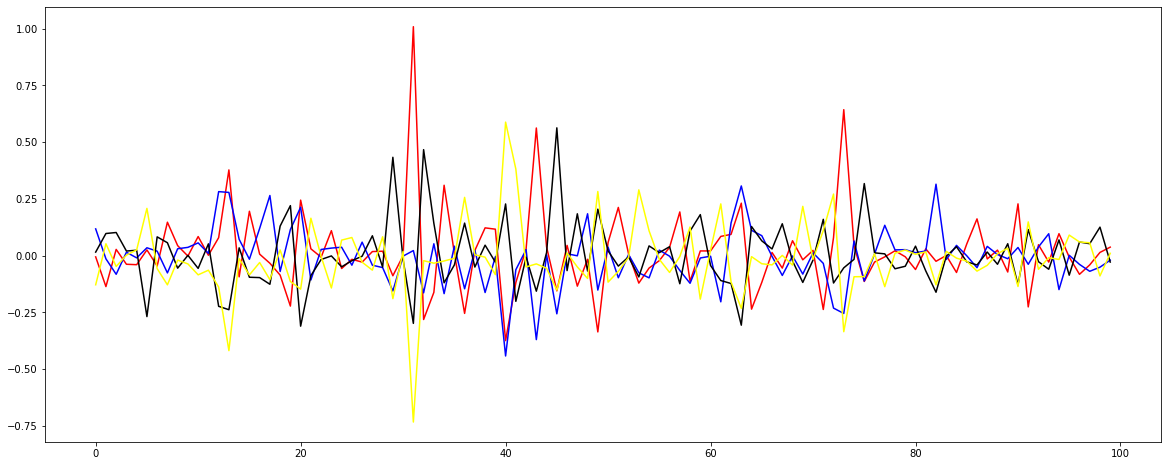

In [27]:
plt.figure(figsize=(20, 8))
X_Values = range(len(precision_float16))
plt.plot(X_Values, precision_float16, c='r')
plt.plot(X_Values, precision_float32, c='blue')
plt.plot(X_Values, precision_float64, c='black')
plt.plot(X_Values, precision_float128, c='yellow')

# CNN

In [36]:
from model_trainingtime_prediction.model_level_utils_cnn import gen_cnn2d, convert_cnn2d_data

CNN_data_points = 500

gen = gen_cnn2d(
    input_shape_lower=8,
    input_shape_upper=29,
    conv_layer_num_lower=1,
    conv_layer_num_upper=51,
    filter_lower=1,
    filter_upper=101,
    dense_layer_num_lower=1,
    dense_layer_num_upper=6,
    dense_size_lower=1,
    dense_size_upper=1001,
    max_pooling_prob=.5,
    input_channels=None,
    paddings=None,
    activations=None,
    optimizers=None,
    losses=None
    )
model_configs_CNN = gen.generate_model_configs(num_model_data=CNN_data_points, progress=True)

100%|██████████| 500/500 [00:00<00:00, 514.73it/s]


In [37]:
def build_cnn2d_model(kwargs_list, layer_orders):
    cnn2d = Sequential()
    for i, lo in enumerate(layer_orders):
        kwargs = kwargs_list[i]
        if lo == "Dense":
            cnn2d.add(Dense(**kwargs))
        elif lo == "Conv2D":
            cnn2d.add(Conv2D(**kwargs))
        elif lo == "MaxPooling2D":
            cnn2d.add(MaxPooling2D(**kwargs))
        elif lo == "Dropout":
            cnn2d.add(Dropout(**kwargs))
        elif lo == "Flatten":
            cnn2d.add(Flatten())
    kwargs = kwargs_list[-1]
#     cnn2d.compile(metrics=['accuracy'], **kwargs["Compile"])
    return cnn2d

In [38]:
from tqdm import tqdm
import random

CNN_batch_sizes = random.choices([2**i for i in range(1, 9)], k=CNN_data_points)
epochs = 10

precisions = [np.float16, np.float32, np.float64, np.float128]

training_data_CNN = []
for _ in range(CNN_data_points):
    training_data_CNN.append([None]*len(precisions))
    
model_optimizers_CNN = []
model_losses_CNN = []

for idx_model, model_config in enumerate(tqdm(model_configs_CNN)):
    batch_size = CNN_batch_sizes[idx_model]
    
    kwargs_list = model_config[0]
    layer_orders = model_config[1]
    input_shape = model_config[2]
    kwargs = kwargs_list[-1]
    optimizer = kwargs['Compile']['optimizer']
    loss = kwargs['Compile']['loss']
    
    model_optimizers_CNN.append(optimizer)
    model_losses_CNN.append(loss)
    
    for idx_precision, precision in enumerate(precisions):
    
        conv2dmodel = build_cnn2d_model(kwargs_list, layer_orders)
        conv2dmodel.compile(metrics=['accuracy'], **kwargs["Compile"])

        out_shape = conv2dmodel.get_config()['layers'][-1]['config']['units']

        # Train
        x = np.ones((batch_size, *input_shape), dtype=precision)
        y = np.ones((batch_size, out_shape), dtype=precision)

        time_callback = TimeHistory()
        conv2dmodel.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

        time_spend = np.mean(time_callback.batch_times[1:])*1000
        
        training_data_CNN[idx_model][idx_precision] = time_spend
    
    
    


100%|██████████| 500/500 [1:18:03<00:00,  9.37s/it]


In [39]:
partail_training_data_CNN = training_data_CNN[:150]

mean_values_CNN = np.array([np.mean(i) for i in partail_training_data_CNN])

In [48]:
precision_float16_CNN = np.array([i[0] for i in partail_training_data_CNN]) #- mean_values_CNN
precision_float32_CNN = np.array([i[1] for i in partail_training_data_CNN]) #- mean_values_CNN
precision_float64_CNN = np.array([i[2] for i in partail_training_data_CNN]) #- mean_values_CNN
precision_float128_CNN = np.array([i[3] for i in partail_training_data_CNN]) - precision_float16_CNN#- mean_values_CNN

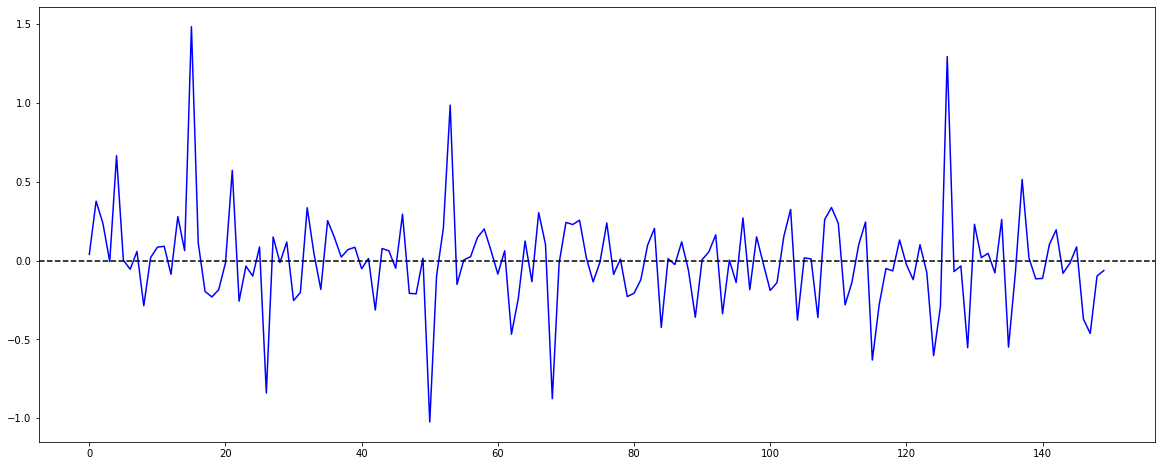

In [51]:
plt.figure(figsize=(20, 8))
X_Values = range(len(precision_float16_CNN))
#plt.plot(X_Values, precision_float16_CNN, c='r')
# plt.plot(X_Values, precision_float32_CNN, c='blue')
# plt.plot(X_Values, precision_float64_CNN, c='black')
plt.plot(X_Values, precision_float128_CNN, c='blue')
plt.axhline(y=0, color='k', linestyle='--')